In [2]:
import os
import sys
import json
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
warnings.filterwarnings('ignore')

pplt.rc.update({
    'reso':'xx-hi',
    'font.size':11,
    'figure.dpi':100,
    'figure.facecolor':'black',
    'savefig.facecolor':'black',
    'axes.facecolor':'white',
    'axes.edgecolor':'white',
    'axes.labelcolor':'white',
    'tick.color':'white',
    'tick.labelcolor':'white',
    'title.color':'white',
    'colorbar.edgecolor':'white'})

In [3]:
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-kernels/scripts/configs.json','r',encoding='utf-8') as f:
    CONFIGS = json.load(f)
SPLITSDIR  = CONFIGS['filepaths']['splits']    
MODELSDIR  = CONFIGS['filepaths']['models']
PREDSDIR   = CONFIGS['filepaths']['predictions']
MODELS     = CONFIGS['models']
SPLIT      = 'valid'   

In [8]:
with xr.open_dataset(os.path.join(SPLITSDIR,f'{SPLIT}.h5'),engine='h5netcdf') as ds:
    truepr = ds.pr.load()

results = {}
for model in MODELS:
    name,description = model['name'],model['description']
    filename = f'{name}_{SPLIT}_predictions.nc'
    filepath = os.path.join(PREDSDIR,filename)
    if os.path.exists(filepath):
        with xr.open_dataset(filepath,engine='h5netcdf') as ds:
            predpr = ds.pr.load()
        ytrue,ypred = xr.align(truepr,predpr,join='inner')
        results[name] = dict(description=description,ytrue=ytrue,ypred=ypred)
print(f'Found {len(results)} completed models for `{SPLIT}`')

nrows = 2
ncols = 4

Found 6 completed models for `valid`


In [9]:
def get_r2(ytrue,ypred,dims=None,landfrac=None,landthresh=0.5):
    dims = list(ytrue.dims) if dims is None else dims
    if landfrac is not None:
        r2values = []
        for mask in [landfrac>=landthresh,landfrac<landthresh]:
            ssres = ((ytrue.where(mask)-ypred.where(mask))**2).sum(dim=dims,skipna=True)
            sstot = ((ytrue.where(mask)-ytrue.where(mask).mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
            r2values.append(1-ssres/sstot)
        return tuple(r2values)
    ssres = ((ytrue-ypred)**2).sum(dim=dims,skipna=True)
    sstot = ((ytrue-ytrue.mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
    return 1-ssres/sstot

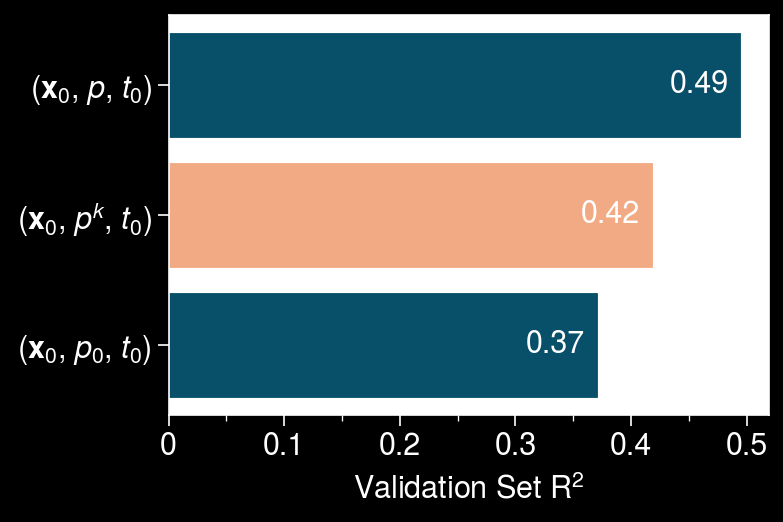

In [64]:
labels, r2s, colors = [], [], []

other = [(runname, result) for runname, result in results.items()
         if runname in ('baseline_full', 'baseline_only_local') or 'vertical' in runname]

def sort_key(item):
    runname, _ = item
    if runname == 'baseline_only_local':
        return (0, runname)
    if runname == 'nonparametric_vertical':
        return (1, runname)
    if runname == 'baseline_full':
        return (2, runname)
    return (3, runname)  

other = sorted(other, key=sort_key)
for runname, result in other:
    description = result['description']
    ytrue, ypred = result['ytrue'], result['ypred']
    r2 = get_r2(ytrue, ypred, dims=None)
    labels.append(description)
    r2s.append(r2)
    colors.append('#f2aa84' if runname == 'nonparametric_vertical' else '#084f6a')

fig, ax = pplt.subplots(nrows=1, ncols=1, refwidth=3, refheight=2)
ax.format(xlabel='Validation Set R$^2$', xticks=0.1, xminorticks=0.05, ylabel='', grid=False)
bars = ax.barh(labels, r2s, color=colors, capsize=3)
for bar, r2 in zip(bars, r2s):
    ax.text(bar.get_width()-0.01, bar.get_y()+bar.get_height()/2, f'{r2:.2f}',
            va='center', ha='right', color='white')
pplt.show()

fig.save('../figs/agu_kernel.jpg',bbox_inches='tight')

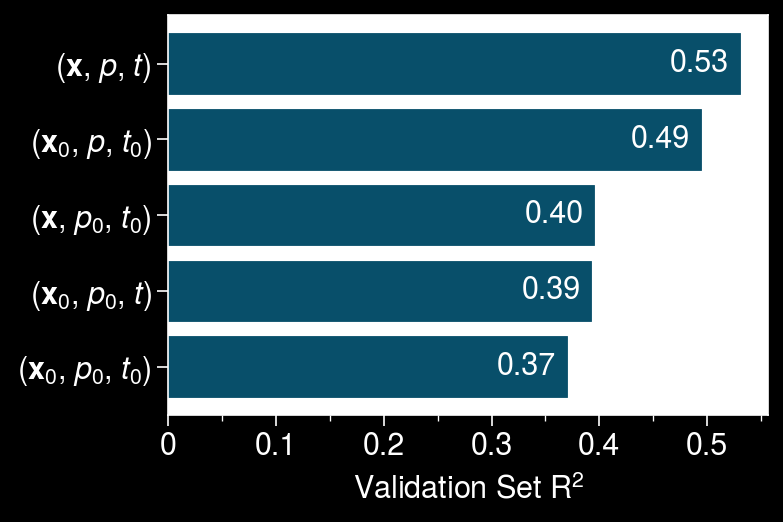

In [10]:
labels, r2s, colors = [], [], []

other = [(runname, result) for runname, result in results.items() if 'baseline' in runname]

def sort_key(item):
    runname, _ = item
    if runname == 'baseline_only_local':
        return (0, runname)
    if runname == 'baseline_only_temporal':
        return (1, runname)
    if runname == 'baseline_only_horizontal':
        return (2, runname)
    if runname == 'baseline_only_vertical':
        return (3, runname)
    if runname == 'baseline_full':
        return (4, runname)
    else:
        None

other = sorted(other, key=sort_key)
for runname, result in other:
    description = result['description']
    ytrue, ypred = result['ytrue'], result['ypred']
    r2 = get_r2(ytrue, ypred, dims=None)
    labels.append(description)
    r2s.append(r2)
    colors.append('#f2aa84' if runname == 'nonparametric_vertical' else '#084f6a')

fig, ax = pplt.subplots(nrows=1, ncols=1, refwidth=3, refheight=2)
ax.format(xlabel='Validation Set R$^2$', xticks=0.1, xminorticks=0.05, ylabel='', grid=False)
bars = ax.barh(labels, r2s, color=colors, capsize=3)
for bar, r2 in zip(bars, r2s):
    ax.text(bar.get_width()-0.01, bar.get_y()+bar.get_height()/2, f'{r2:.2f}',
            va='center', ha='right', color='white')
pplt.show()

fig.save('../figs/agu_baseline.jpg',bbox_inches='tight')